# Introduccion a la Holografia

## Reconstruccion de hologramas de Fresnel

In [ ]:
import numpy as np
import scipy.fft as sft
import matplotlib.pyplot as plt
from PIL import Image as im

def convft(U,H,dx):
    """
    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    U2=sft.fft2(sft.fftshift(U))*(dx**2)
    U2=H*U2
    U2=sft.ifftshift(sft.ifft2(U2)*(1/dx**2))
    return U2

def circ(x): # FUNCION circulo EN 2D
        s=np.zeros(x.shape)
        s[(x)<1]=1.0
        return s
    

def tajada(M1,M2,x,y):
    """
    Esta funcion permite recortar una seccion centrada en x, y del array M1 de
    tamaño igual al array M2. Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo del que se recorta una sección.
    M2 : Array Numpy
        Arreglo que determina el tamaño del recorte.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a recortar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M2.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz recortada debe ser mas pequeña que la original')
    MC=M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((n+nn)*0.5)+x)]
    return MC

def fusion(M1,M2,x,y):
    """
    Esta funcion permite insertar M2 a una seccion centrada en (x, y) del array M1.
    Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo al que se inserta una sección.
    M2 : Array Numpy
        Arreglo a insertar.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a insertar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M1.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz a instertar debe ser mas pequeña que la original')
    M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]=M2
    MC=np.copy(M1)
    return MC

def ftfresnel(M,N,dx,wl,z):
    
    """
    Esta funcion genera una funcion de transferencia  de tamaño (n,m) para la transformada de fresnel con distancia z tamaño de píxel dx y longitud de onda wl.
    Usar tamaños cuadrados para evitar artefactos de anisotropia, o generar una funcion cuadrada de mayor tamaño y recortar el tamaño deseado. 
    El programa determina si se genera la funcion de transferencia directamente.
    
    Parameters
    ----------
    M : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    N : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    dx : Float
        Tamaño de píxel
    wl : Float
        Longitud de onda
    z : Float
        Distancia de propagacion.

    Returns
    -------
    H
        Arreglo de numpy con tamaño N,M

    """
    Lx=M*dx
    Ly=N*dx
    k=2*np.pi/wl
    x=np.arange(-Lx/2,Lx/2,dx)
    y=np.arange(-Ly/2,Ly/2,dx)
    fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
    fy=np.arange(-1/(2*dx),1/(2*dx),1/Ly)
    zmax=(dx*Lx)/wl
    FX,FY=np.meshgrid(fx,fy)
    H=np.exp(-1j*wl*z*np.pi*(FX**2+FY**2))
    H=sft.fftshift(H)
    return H

def irfresnel(M,N,dx,wl,z):
    
    """
    Esta funcion genera una funcion de tranfserencia  de tamaño (n,m) para la transformada de fresnel con distancia z tamaño de píxel dx y longitud de onda wl.
    Usar tamaños cuadrados para evitar artefactos de anisotropia, o generar una funcion cuadrada de mayor tamaño y recortar el tamaño deseado. 
    El programa genera la funcion de transferencia por medio de la respuesta al impulso en base a los paramtros introducidos.
    
    Parameters
    ----------
    M : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    N : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    dx : Float
        Tamaño de píxel
    wl : Float
        Longitud de onda
    z : Float
        Distancia de propagacion.

    Returns
    -------
    H
        Arreglo de numpy con tamaño N,M

    """
    Lx=M*dx
    Ly=N*dx
    k=2*np.pi/wl
    x=np.arange(-Lx/2,Lx/2,dx)
    y=np.arange(-Ly/2,Ly/2,dx)
    fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
    fy=np.arange(-1/(2*dx),1/(2*dx),1/Ly)
    zmax=(dx*Lx)/wl
    X,Y=np.meshgrid(x,y)
    h=(1/(1j*wl*z))*np.exp(1j*k/(2*z)*(X**2+Y**2))
    H=sft.fft2(sft.fftshift(h))*(dx**2)  
    return H

2748 3840
0.013223458646616539


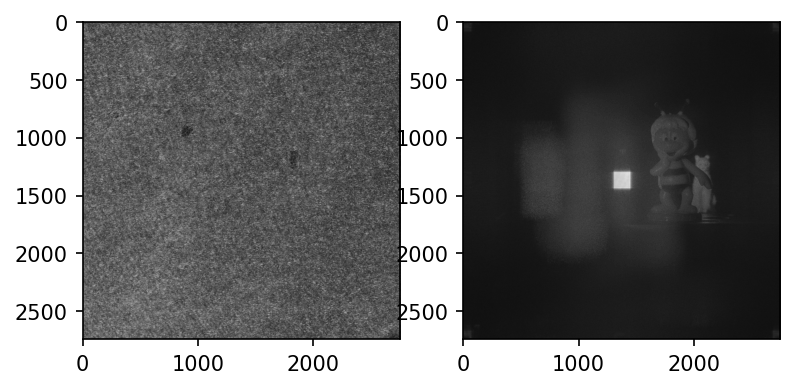

In [ ]:
I=im.open('./hag3.bmp')
I=np.asarray(I)
I=I*1.
I=I/np.max(np.max(I))
[n,m]=I.shape
M=min(n,m)
print(n,m)
Q=np.zeros([M-1,M-1])
E=tajada(I,Q,0,0)

dx=1.6E-6 #Tamaño de pixel
wl=532E-9 #longitud de onda
L=M*dx    #Tamaño espacio
zc=dx*L/wl #distancia critica
print(zc)
F=sft.ifftshift(sft.fft2(sft.fftshift(E))) #Cuando el plano de reconstruccion es muy lejano se puede "acercar" con una FT
ft=ftfresnel(M-1,M-1,dx,wl,0.0007) #Se genera el kernel de la propagacion
F=convft(F,ft,dx)  #Se propaga del plano de fourier al de reconstruccion
R=F*np.conj(F)  #Intensidad del campo
R=abs(R) #Se convierte el campo en un array de numeros reales
R=R/np.max(np.max(R)) #Se normaliza
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(E,cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(R**0.2,cmap='gray')

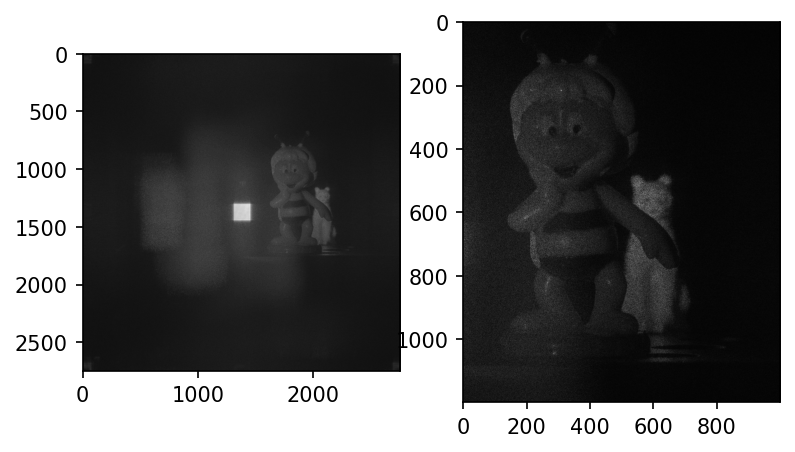

In [ ]:
R2=tajada(R,np.zeros([1200,1000]),600,-100)
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(R**0.2,cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(R2**0.4,cmap='gray')

## Reconstruccion de hologramas de Fourier

2748 3840
0.013223458646616539


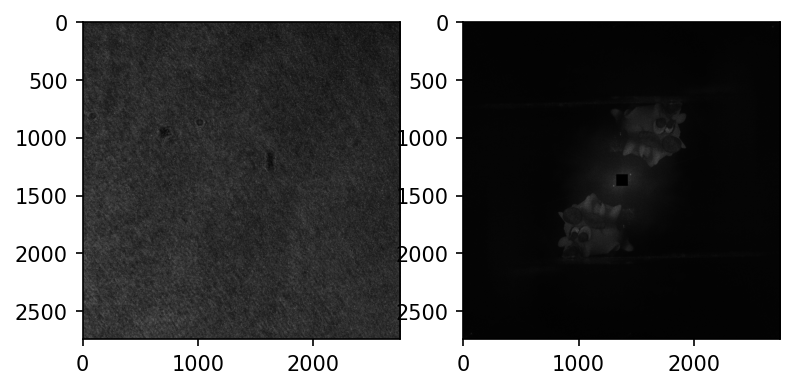

In [ ]:
I=im.open('./hrata.bmp')
I=np.asarray(I)
I=I*1.
I=I/np.max(np.max(I))
[n,m]=I.shape
M=min(n,m)
print(n,m)
Q=np.zeros([M-1,M-1])
E=tajada(I,Q,0,0)

dx=1.6E-6
wl=532E-9
L=M*dx
zc=dx*L/wl
print(zc)
F=sft.ifftshift(sft.fft2(sft.fftshift(E)))

R=F*np.conj(F)
R=abs(R)
R=R/np.max(np.max(R))
R=fusion(R,np.zeros([100,100]),0,0)
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(E,cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(R**0.4,cmap='gray')

## Algoritmo de Gerchberg-Saxton


iteracion  0


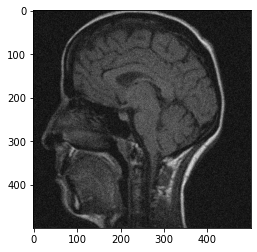

iteracion  1


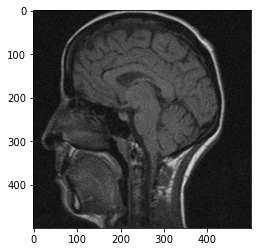

iteracion  2


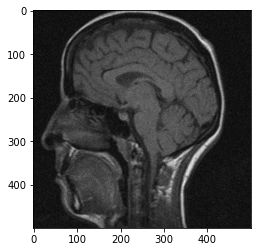

iteracion  3


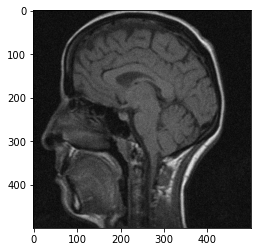

iteracion  4


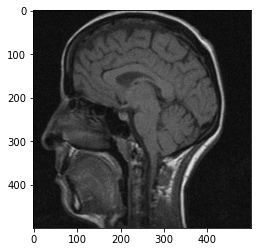

iteracion  5


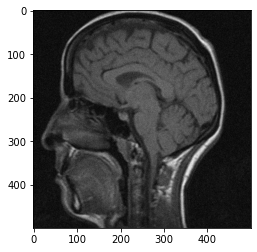

iteracion  6


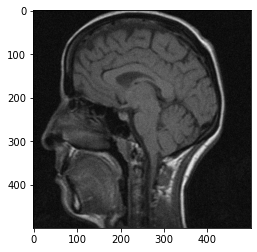

iteracion  7


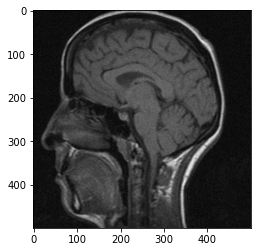

iteracion  8


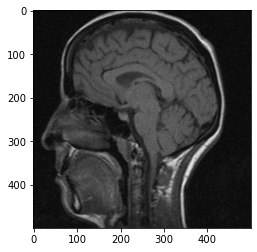

iteracion  9


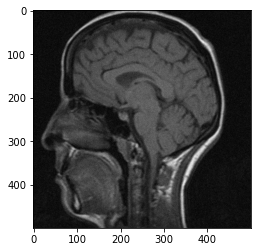

iteracion  10


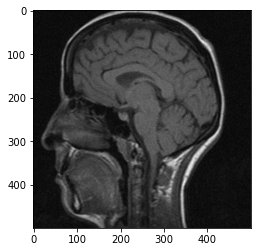

iteracion  11


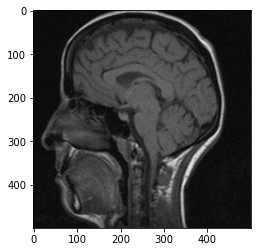

iteracion  12


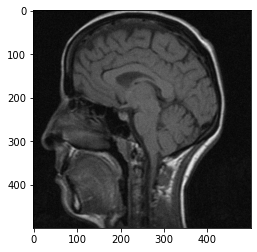

iteracion  13


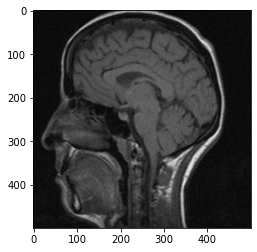

iteracion  14


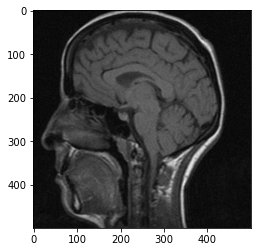

fase holograma


<function matplotlib.pyplot.show(close=None, block=None)>

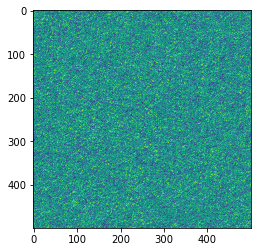

In [ ]:
M=500
dx=0.5
L=dx*M
import time
import os

def clear():
    os.system('cls')
    
I=im.open('./head.bmp')
I=I.resize([M,M])
I=np.asarray(I)
I=I[:,:,1]
I=I*1.
I=I/np.max(np.max(I))
I=I-np.min(np.min(I))

ug=(I)*np.exp(1j*2*np.pi*np.random.rand(M,M))

for i in range(15):
    U=sft.ifftshift(sft.fft2(sft.fftshift(ug)))
    U=np.exp(1j*np.angle(U))
    ug=sft.ifftshift(sft.ifft2(sft.fftshift(U)))
    R=ug*np.conj(ug)
    R=abs(R)
    plt.imshow(R**0.5,cmap='gray')
    print('iteracion ',i)
    plt.show()
    time.sleep(1)
    ug=I*np.exp(1j*np.angle(ug))
    
H=U
print( 'fase holograma')
plt.imshow(np.angle(H))
plt.show
